#Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive')

#Additional Imports

In [3]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib as mpl

#Standard imports

In [4]:
!pip install pytorch_lightning
import torch
import numpy as np
import torch.nn as nn
import dynamic_selection as ds
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Subset, TensorDataset
from torchmetrics import Accuracy, AUROC
from dynamic_selection import MaskingPretrainer, GreedyDynamicSelection,BaseModel
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 44.8 MB/s eta 0:00:00


#Dataset

In [5]:
# Load dataset.
dataset = ds.data.load_p2hev()
d_in = dataset.input_size    # 57
d_out = dataset.output_size  # 2
# Normalize and split dataset.
mean = (dataset.tensors[0]).mean(dim=0)
dataset.tensors = (dataset.tensors[0] - mean, dataset.tensors[1])
train_dataset, val_dataset, test_dataset = ds.data.data_split(dataset)
dataset.features

array(['VelocityRef:1', '<xdot>', '<BattSoc>', '<BattPwr>',
       '<Cltch1State>', '<Cltch2State>', '<BattV>', '<TransGear>',
       '<EngSpd>', '<IntkVlvLift>', '<EngTrq>', '<ThrPosPct>',
       '<WgAreaPct>', '<EgrVlvAreaPct>', '<VarCompRatioPos>', '<Acc>',
       '<Dec>', '<IgSw>', '<Chrg>', 'TransGear', 'BrkCmd', 'Cltch1Cmd',
       '<MotTrq>', '<StartTrq>', 'StartCmd', 'MotTrqCmd', 'BattCrnt:1',
       'MotPwrElec:1', 'MotPwrMech:1', 'IntkVlvLiftCmd', 'FuelMainSoi',
       'FuelFlw'], dtype='<U17')

In [6]:
# Prepare dataloaders.
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=2048,shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=2048, pin_memory=True)

#Networks

In [7]:
hidden = 128
dropout = 0.3
class MockupModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.ModuleDict({
            'lstm1': nn.LSTM(
                input_size=2*d_in,    # 45, see the data definition
                hidden_size=hidden,  # Can vary
                dropout=(0.3),
            ),
            'lstm2': nn.LSTM(
                input_size=hidden,    # 45, see the data definition
                hidden_size=hidden,  # Can vary
                dropout=(0.3),
            ),
            'ReLU1' : nn.ReLU(inplace=False),
            'linear1': nn.Linear(
                in_features=hidden,
                out_features=hidden,),
            'ReLU2' : nn.ReLU(inplace=False),
            'linear2': nn.Linear(
                in_features=hidden,
                out_features=d_out),

        })
    def forward(self, x):

        # From [batches, seqs, seq len, features]
        # to [seq len, batch data, features]
        #x = x.view(x_seq_len, -1, 2*d_in)

        # Data is fed to the LSTM
        out,_  = self.model['lstm1'](x)
        #print(f'lstm output={out.size()}')

        #out,_  = self.model['lstm2'](out)
        # From [seq len, batch, num_directions * hidden_size]
        # to [batches, seqs, seq_len,prediction]
        #out = out.view(x_batches, x_seqs, x_seq_len, -1)
        #print(f'transformed output={out.size()}')
        #out  = self.model['ReLU1'](out)

        # Data is fed to the Linear layer
        #out = self.model['linear1'](out)
        out  = self.model['ReLU2'](out)
        out = self.model['linear2'](out)
        #print(f'linear output={out.size()}')

        # The prediction utilizing the whole sequence is the last one
        #y_pred = out[:, :, -1].unsqueeze(-1)
        #print(f'y_pred={y_pred.size()}')

        return out

In [8]:
#predictor = MockupModel()

In [9]:
hidden = 128
dropout = 0.3
class MockupModelS(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.ModuleDict({
            'lstm1': nn.LSTM(
                input_size=2*d_in,    # 45, see the data definition
                hidden_size=hidden,  # Can vary
                dropout=(0.3),
            ),
            'lstm2': nn.LSTM(
                input_size=hidden,    # 45, see the data definition
                hidden_size=hidden,  # Can vary
                dropout=(0.3),
            ),
            'ReLU1' : nn.ReLU(inplace=False),
            'linear1': nn.Linear(
                in_features=hidden,
                out_features=hidden,),
            'ReLU2' : nn.ReLU(inplace=False),
            'linear2': nn.Linear(
                in_features=hidden,
                out_features=d_in),

        })
    def forward(self, x):

        # From [batches, seqs, seq len, features]
        # to [seq len, batch data, features]
        #x = x.view(x_seq_len, -1, 2*d_in)

        # Data is fed to the LSTM
        out,_  = self.model['lstm1'](x)
        #print(f'lstm output={out.size()}')

        #out,_  = self.model['lstm2'](out)
        # From [seq len, batch, num_directions * hidden_size]
        # to [batches, seqs, seq_len,prediction]
        #out = out.view(x_batches, x_seqs, x_seq_len, -1)
        #print(f'transformed output={out.size()}')
        #out  = self.model['ReLU1'](out)

        # Data is fed to the Linear layer
        #out = self.model['linear1'](out)
        out  = self.model['ReLU2'](out)
        out = self.model['linear2'](out)
        #print(f'linear output={out.size()}')

        # The prediction utilizing the whole sequence is the last one
        #y_pred = out[:, :, -1].unsqueeze(-1)
        #print(f'y_pred={y_pred.size()}')

        return out

In [10]:
#selector = MockupModelS()

In [11]:
# Set up networks
hidden = 128
dropout = 0.3

predictor = nn.Sequential(
    nn.Linear(2 * d_in, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, d_out))

selector = nn.Sequential(
    nn.Linear(2 * d_in, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, d_in))

In [12]:
# Pretrain predictor.
mask_layer = ds.utils.MaskLayer(append=True)
pretrain = MaskingPretrainer(predictor, mask_layer).cuda()
pretrain.fit(
    train_loader,
    val_loader,
    lr=1e-3,
    nepochs=35,#100
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

--------Epoch 1--------
Val loss = 1.0974

--------Epoch 2--------
Val loss = 1.0888

--------Epoch 3--------
Val loss = 1.0810

--------Epoch 4--------
Val loss = 1.0755

--------Epoch 5--------
Val loss = 1.0698

--------Epoch 6--------
Val loss = 1.0571

--------Epoch 7--------
Val loss = 1.0269

--------Epoch 8--------
Val loss = 1.0015

--------Epoch 9--------
Val loss = 0.9829

--------Epoch 10--------
Val loss = 0.9747

--------Epoch 11--------
Val loss = 0.9750

--------Epoch 12--------
Val loss = 0.9717

--------Epoch 13--------
Val loss = 0.9724

--------Epoch 14--------
Val loss = 0.9676

--------Epoch 15--------
Val loss = 0.9641

--------Epoch 16--------
Val loss = 0.9644

--------Epoch 17--------
Val loss = 0.9632

--------Epoch 18--------
Val loss = 0.9604

--------Epoch 19--------
Val loss = 0.9605

--------Epoch 20--------
Val loss = 0.9625

--------Epoch 21--------
Val loss = 0.9625

Epoch 00021: reducing learning rate of group 0 to 2.0000e-04.
--------Epoch 22-------

In [13]:
# Train selector and predictor jointly.
gdfs = GreedyDynamicSelection(selector, predictor, mask_layer).cuda()

In [14]:
gdfs.fit(
    train_loader,
    val_loader,
    dataset.features,
    lr=1e-3,
    nepochs=35,#250
    #start_temp=0.3,
    #temp_steps=1,
    max_features=35,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True
    )

Starting training with temp = 1.0000

epoch is 0

--------Epoch 1 (1 total)--------
Val loss = 0.5906, Zero-temp loss = 0.5948

epoch is 1

--------Epoch 2 (2 total)--------
Val loss = 0.5776, Zero-temp loss = 0.5830

epoch is 2

--------Epoch 3 (3 total)--------
Val loss = 0.5678, Zero-temp loss = 0.5729

epoch is 3

--------Epoch 4 (4 total)--------
Val loss = 0.5632, Zero-temp loss = 0.5700

epoch is 4

--------Epoch 5 (5 total)--------
Val loss = 0.5514, Zero-temp loss = 0.5577

epoch is 5

--------Epoch 6 (6 total)--------
Val loss = 0.5378, Zero-temp loss = 0.5442

epoch is 6

--------Epoch 7 (7 total)--------
Val loss = 0.5395, Zero-temp loss = 0.5467

epoch is 7

--------Epoch 8 (8 total)--------
Val loss = 0.5358, Zero-temp loss = 0.5444

epoch is 8

--------Epoch 9 (9 total)--------
Val loss = 0.5222, Zero-temp loss = 0.5296

epoch is 9

--------Epoch 10 (10 total)--------
Val loss = 0.5246, Zero-temp loss = 0.5320

epoch is 10

--------Epoch 11 (11 total)--------
Val loss = 

In [15]:
gdfs.selector.load_state_dict(torch.load('/content/drive/MyDrive/selPre/selector'))
gdfs.predictor.load_state_dict(torch.load('/content/drive/MyDrive/selPre/predictor'))

<All keys matched successfully>

# Evaluate performance

- AUROC and top-1 accuracy increase quickly with the number of selections
- Performance can often be improved by increasing the `patience` parameter, or increasing the number of temperature steps (`temp_steps`)

In [16]:
# For saving results.
num_features = list(range(1, 11)) + list(range(15, 30, 5))
auroc_list = []
acc_list = []

# Metrics (softmax is applied automatically in recent versions of torchmetrics).
auroc_metric = lambda pred, y: AUROC(task='multiclass', num_classes=d_out)(pred.softmax(dim=1), y)
acc_metric = Accuracy(task='multiclass', num_classes=d_out)

# Evaluate.
for num in num_features:
    auroc, acc = gdfs.evaluate(test_loader, num, (auroc_metric, acc_metric))
    auroc_list.append(auroc)
    acc_list.append(acc)
    print(f'Num = {num}, AUROC = {100*auroc:.2f}, Acc = {100*acc:.2f}')

Num = 1, AUROC = 84.11, Acc = 67.20
Num = 2, AUROC = 86.30, Acc = 68.55
Num = 3, AUROC = 87.51, Acc = 69.99
Num = 4, AUROC = 91.44, Acc = 76.53
Num = 5, AUROC = 92.97, Acc = 78.57
Num = 6, AUROC = 93.57, Acc = 78.67
Num = 7, AUROC = 93.80, Acc = 79.24
Num = 8, AUROC = 94.06, Acc = 79.49
Num = 9, AUROC = 93.67, Acc = 79.13
Num = 10, AUROC = 93.29, Acc = 77.99
Num = 15, AUROC = 94.62, Acc = 81.32
Num = 20, AUROC = 94.80, Acc = 80.85
Num = 25, AUROC = 95.67, Acc = 82.89


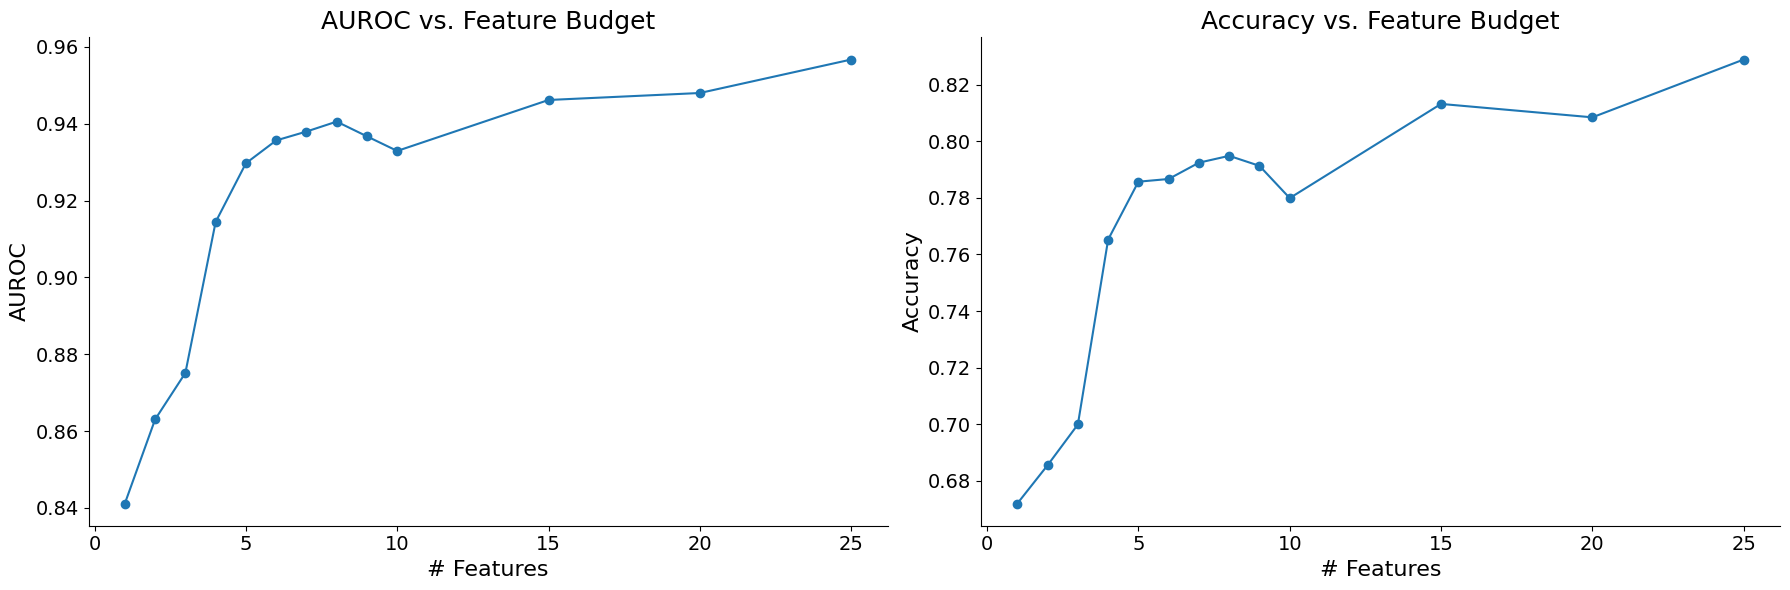

In [17]:
# Plot results
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))

# AUROC
plt.sca(axarr[0])
plt.plot(num_features, auroc_list, marker='o')
plt.xlabel('# Features', fontsize=16)
plt.ylabel('AUROC', fontsize=16)
plt.title('AUROC vs. Feature Budget', fontsize=18)
plt.tick_params(labelsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Accuracy
plt.sca(axarr[1])
plt.plot(num_features, acc_list, marker='o')
plt.xlabel('# Features', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy vs. Feature Budget', fontsize=18)
plt.tick_params(labelsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

In [18]:
cost_false_positive = 2
cost_false_negative = 4

x , y_train_tensor = ds.data.get_xy(train_dataset)
x_np=x.numpy()
x_train_df=pd.DataFrame.from_records(x_np)
unique_elements, counts = torch.unique(y_train_tensor, return_counts=True)
for i in range(unique_elements.size(0)):
  if unique_elements[i]==0:
    non_fault = counts[i]
    break
total = torch.sum(counts)

x , y_val_tensor = ds.data.get_xy(val_dataset)
x_np=x.numpy()
x_cv_df=pd.DataFrame.from_records(x_np)
unique_elements, counts = torch.unique(y_val_tensor, return_counts=True)
for i in range(unique_elements.size(0)):
  if unique_elements[i]==0:
    non_fault += counts[i]
total += torch.sum(counts)

P_present = non_fault/total
P_absent = 1 - P_present

In [19]:
# helper function to calculate probability of correctly giving signal when present
def get_signal_present(prediction, ground_truth):
    present_index = list()
    for i in range(len(ground_truth)):
        if ground_truth[i] == 0:
            present_index.append(i)

    counter = 0
    for index in present_index:
        if prediction[index] == 0:
            counter += 1

    return counter/len(present_index)

# helper function to calculate probability of correctly giving signal when present
# there should be a more generic way using operator module to merge this with the one above.
def get_no_signal_absent(prediction, ground_truth):
    absent_index = list()
    for i in range(len(ground_truth)):
        if ground_truth[i] != 0:
            absent_index.append(i)

    counter = 0
    for index in absent_index:
        if prediction[index] != 0:
            counter += 1
    return counter/len(absent_index)

In [20]:
def get_expected_cost(prediction,GT_tensor):
  # get P(signal|present) and P(no signal|absent)
    ground_truth = GT_tensor.tolist()
    #prediction = prediction_t.tolist()
    P_signal_present = get_signal_present(prediction, ground_truth)
    P_no_signal_absent = get_no_signal_absent(prediction, ground_truth)
    P_signal_absent = 1 - P_no_signal_absent
    P_no_signal_present = 1 - P_signal_present

  # get P(signal)
    P_signal = P_present * P_signal_present + P_absent * P_signal_absent
    P_no_signal = 1 - P_signal

  # bayesian probability
    P_absent_signal = (P_signal_absent * P_absent) / P_signal
    P_present_signal = (P_signal_present * P_present) / P_signal
    P_absent_no_signal = (P_no_signal_absent * P_absent) / P_no_signal
    P_present_no_signal = (P_no_signal_present * P_present) / P_no_signal

  #calculate the evoi
    evoi = P_signal * min(cost_false_positive * P_absent_signal, cost_false_negative * P_present_signal) + P_no_signal * min(cost_false_positive * P_absent_no_signal, cost_false_negative * P_present_no_signal)

    return evoi

# Plot selections

In [21]:
# Generate selections for entire test set.
num_features = range(1, 25)
p_list = []

for num in num_features:
  print(str(num)+'\n')
  x, y = ds.data.get_xy(test_dataset)
  x_np=x.numpy()
  x_test_df=pd.DataFrame(x_np)
  pred1, x_masked, m = gdfs(x.cuda(), max_features=num)
  pred=(pred1.cpu()).detach().numpy()
  pred = np.argmax(pred, axis=-1)
  p = m.mean(dim=0)
  p_list.append(p.cpu().numpy())

  sensors_index=np.array(p_list)
  sorted_indices = np.flip(np.argsort(sensors_index))
  sensors=[]
  for i in range(0,num):
    sensors = np.append(sensors, dataset.features[sorted_indices[0][i]])
  sensors=sensors.tolist()
  print(sensors)
  base_indices=sorted_indices[0][num:].tolist()
  sorted_indices=sorted_indices[0][0:num].tolist()
  print(get_expected_cost(pred,y))


1

['<BattSoc>']
tensor(0.9637)
2

['<BattSoc>', '<ThrPosPct>']
tensor(0.8885)
3

['<BattSoc>', '<ThrPosPct>', '<EngTrq>']
tensor(0.9343)
4

['<BattSoc>', '<ThrPosPct>', '<EngTrq>', '<xdot>']
tensor(0.7316)
5

['<BattSoc>', '<EngTrq>', '<ThrPosPct>', '<xdot>', '<TransGear>']
tensor(0.6684)
6

['<BattSoc>', '<ThrPosPct>', '<EngTrq>', '<xdot>', '<TransGear>', 'MotPwrMech:1']
tensor(0.6542)
7

['<BattSoc>', '<ThrPosPct>', '<EngTrq>', '<TransGear>', '<xdot>', 'MotPwrMech:1', '<BattV>']
tensor(0.6413)
8

['<BattSoc>', '<ThrPosPct>', '<EngTrq>', '<TransGear>', '<xdot>', 'TransGear', 'FuelMainSoi', 'MotPwrMech:1']
tensor(0.6240)
9

['<BattSoc>', '<ThrPosPct>', '<TransGear>', '<EngTrq>', '<xdot>', 'FuelMainSoi', 'TransGear', 'MotPwrMech:1', '<BattV>']
tensor(0.6483)
10

['<BattSoc>', '<ThrPosPct>', '<TransGear>', '<EngTrq>', '<xdot>', 'FuelMainSoi', 'TransGear', 'MotPwrMech:1', '<Cltch1State>', '<BattV>']
tensor(0.6889)
11

['<BattSoc>', '<ThrPosPct>', '<EngTrq>', '<TransGear>', '<xdot>', 'Fue